In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import numpy as np
import os
import pandas as pd
!pip install tabulate
from tabulate import tabulate
import matplotlib.pyplot as plt
import torchvision
from torchvision.models import resnet50
!pip install lightning
import lightning.pytorch as pl
import torchvision.models as tmodels



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 69.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 83.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 97.8 MB/s eta 0:00:00


## Size of Distillation Models

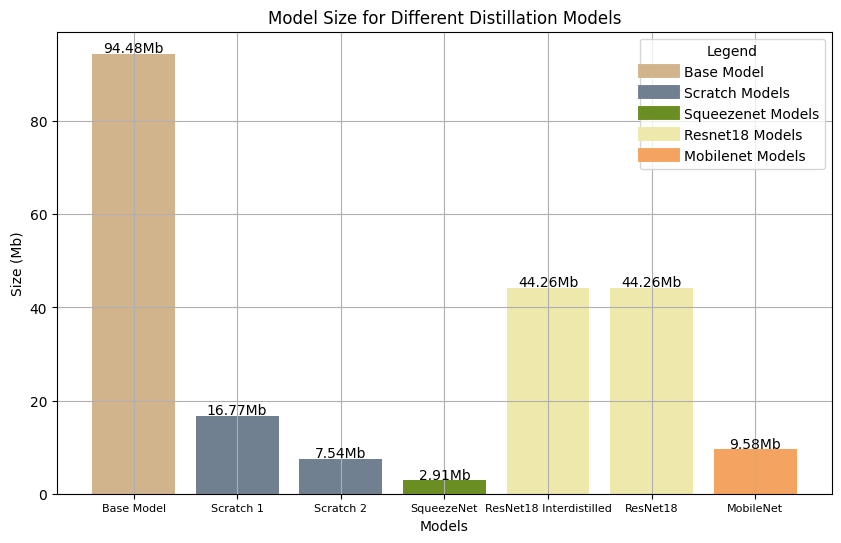

In [13]:
original_model_size= os.path.getsize('models/teacher.pth') / 1024/1000
student4_kl= os.path.getsize('models/student4_kl.pth') / 1024/1000
student2_kl= os.path.getsize('models/student2_kl.pth') / 1024/1000
squeezenet_distilled= os.path.getsize('models/squeezenet_distilled.pth') / 1024/1000
resnet18_inter_distilled= os.path.getsize('models/resnet18_distilled_intermediate.pth') / 1024/1000
resnet18_distilled= os.path.getsize('models/resnet18_distilled_weights.pth') / 1024/1000
mobilenet_distilled= os.path.getsize('models/mobilenet_distilled2_weights.pth') / 1024/1000

# Etiquetas para cada modelo
labels = [
    "Base Model",
    "Scratch 1",
    "Scratch 2",
    "SqueezeNet",
    "ResNet18 Interdistilled",
    "ResNet18",
    "MobileNet"
]

# Valores de tamaño
sizes = [
    original_model_size,
    student4_kl,
    student2_kl,
    squeezenet_distilled,
    resnet18_inter_distilled,
    resnet18_distilled,
    mobilenet_distilled,
]

# Crear la gráfica de barras
plt.figure(figsize=(10, 6))
plt.bar(labels, sizes, color=['tan', 'slategrey', 'slategrey', 'olivedrab', 'palegoldenrod', 'palegoldenrod', 'sandybrown'])

# Agregar títulos y etiquetas
plt.title('Model Size for Different Distillation Models')
plt.xlabel('Models')
plt.ylabel('Size (Mb)')

# Mostrar valores exactos encima de cada barra
for i, v in enumerate(sizes):
    plt.text(i, v + 0.2, f'{v:.2f}Mb', ha='center', fontsize=10)
    
legend_handles = [
    plt.Line2D([0], [0], color='tan', lw=10, label='Base Model'),
    plt.Line2D([0], [0], color='slategrey', lw=10, label='Scratch Models'),
    plt.Line2D([0], [0], color='olivedrab', lw=10, label='Squeezenet Models'),
    plt.Line2D([0], [0], color='palegoldenrod', lw=10, label='Resnet18 Models'),
    plt.Line2D([0], [0], color='sandybrown', lw=10, label='Mobilenet Models'),
]
plt.legend(handles=legend_handles, title='Legend', loc='upper right', bbox_to_anchor=(1.0, 1.0))
# Mostrar la gráfica
#plt.ylim([min(accuracies) - 5, 100])  # Ajustar el eje y para mejor visualización
plt.grid(True)
plt.xticks(fontsize=8)
plt.savefig('size_distillation.png', dpi=300, bbox_inches='tight')  # Ajustar DPI y bordes para calidad óptima
plt.show()

## Acuracy of Distillation Models

In [14]:
class StNN(nn.Module):
    def __init__(self, num_classes=10):
        super(StNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 256, kernel_size=3, padding=1),  # Aumentamos los filtros
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),  # Nueva capa convolucional
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(32*7*7, 1024),  # Aumentamos el tamaño de entrada y salida
            nn.ReLU(),
            nn.Dropout(0.3),       # Aumentamos el dropout para evitar sobreajuste
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [15]:
# Transformaciones para el dataset CIFAR-10
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Cambiamos el tamaño de las imágenes para que se ajusten a ResNet-50
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalizamos las imágenes
])
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)
def test(path, device, test_loader):
    print(path)
    if 'squeezenet' in path:
        model = tmodels.squeezenet1_0(pretrained=True)
        model.classifier[1] = nn.Conv2d(512, 10, kernel_size=(1, 1), stride=(1, 1))  # Cambiar para 10 clases
        model.to(device)
        model.load_state_dict(torch.load(path))
    elif 'mobilenet' in path:
        model = tmodels.mobilenet_v2(weights="IMAGENET1K_V2")
        model.classifier = nn.Sequential(
            nn.Dropout(0.5),  # Dropout con probabilidad 0.5
            nn.Linear(model.last_channel, 128),  # Capa completamente conectada de 128 neuronas
            nn.ReLU(),  # Activación ReLU
            nn.Linear(128, 10)  # Capa de salida para 10 clases (CIFAR-10)
            )
        model.to(device)
        model.load_state_dict(torch.load(path))
    elif 'resnet18' in path:
        model = tmodels.resnet18(pretrained=True)
        model.fc = nn.Sequential(
            nn.Linear(model.fc.in_features, 256),  # Capa de 256 neuronas
            nn.ReLU(),  # Activación ReLU
            nn.Linear(256, 10)  # Capa de salida para 10 clases (CIFAR-10)
            )
        model.to(device)
        model.load_state_dict(torch.load(path))
    else:
        model=torch.load(path)
        model.to(device)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    acc = 100. * correct / len(test_loader.dataset)
    return acc

Files already downloaded and verified


In [16]:
class StNN(nn.Module):
    def __init__(self, num_classes=10):
        super(StNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [17]:
models=['models/teacher.pth',
'models/student4_kl.pth',
'models/student2_kl.pth',
'models/squeezenet_distilled.pth',
'models/resnet18_distilled_intermediate.pth',
'models/resnet18_distilled_weights.pth',
'models/mobilenet_distilled2_weights.pth']
accuracies=[]
for i in range(len(models)):
    acc=test(models[i], 'cuda', testloader)
    accuracies.append(acc)


models/teacher.pth


/tmp/ipykernel_130/3166366029.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model=torch.load(path)


models/student4_kl.pth
models/student2_kl.pth
models/squeezenet_distilled.pth


/root/miniconda3/envs/dl/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/envs/dl/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-b66bff10.pth
100%|███████████████████████████████████████████████████████████| 4.78M/4.78M [00:00<00:00, 30.3MB/s]
/tmp/ipykernel_130/3166366029.py:15: FutureWarning: You are using `torch.load` with `weights_o

models/resnet18_distilled_intermediate.pth


/root/miniconda3/envs/dl/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|███████████████████████████████████████████████████████████| 44.7M/44.7M [00:00<00:00, 89.1MB/s]
/tmp/ipykernel_130/3166366029.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#u

models/resnet18_distilled_weights.pth


Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


models/mobilenet_distilled2_weights.pth


100%|███████████████████████████████████████████████████████████| 13.6M/13.6M [00:00<00:00, 58.7MB/s]
/tmp/ipykernel_130/3166366029.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental

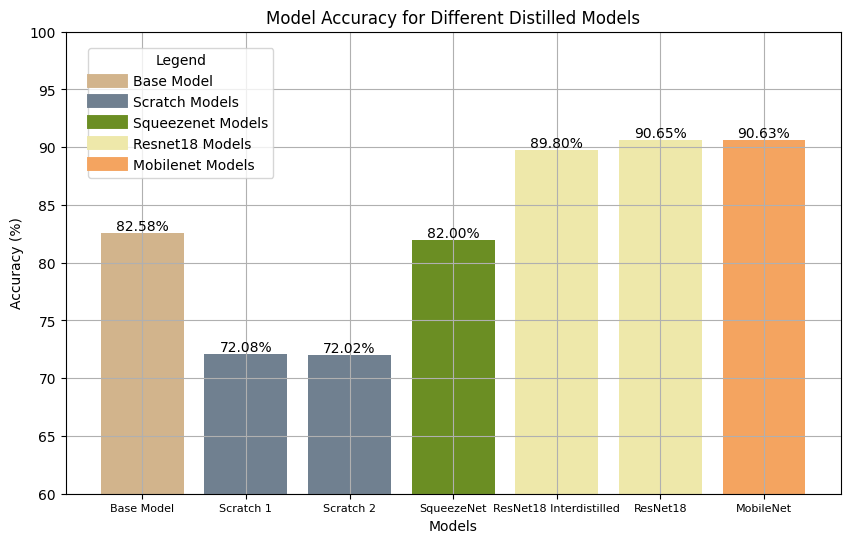

In [19]:
labels = [
    "Base Model",
    "Scratch 1",
    "Scratch 2",
    "SqueezeNet",
    "ResNet18 Interdistilled",
    "ResNet18",
    "MobileNet"
]
# Crear la gráfica de barras
plt.figure(figsize=(10, 6))
plt.bar(labels, accuracies, color=['tan', 'slategrey', 'slategrey', 'olivedrab', 'palegoldenrod', 'palegoldenrod', 'sandybrown'])

# Agregar títulos y etiquetas
plt.title('Model Accuracy for Different Distilled Models')
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')

# Mostrar valores exactos encima de cada barra
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.2, f'{v:.2f}%', ha='center', fontsize=10)
legend_handles = [
    plt.Line2D([0], [0], color='tan', lw=10, label='Base Model'),
    plt.Line2D([0], [0], color='slategrey', lw=10, label='Scratch Models'),
    plt.Line2D([0], [0], color='olivedrab', lw=10, label='Squeezenet Models'),
    plt.Line2D([0], [0], color='palegoldenrod', lw=10, label='Resnet18 Models'),
    plt.Line2D([0], [0], color='sandybrown', lw=10, label='Mobilenet Models'),
]
plt.legend(handles=legend_handles, title='Legend', loc='upper left', bbox_to_anchor=(0.02, 0.98))
# Mostrar la gráfica
#plt.ylim([min(accuracies) - 5, 100])  # Ajustar el eje y para mejor visualización
plt.grid(True)
plt.ylim(60, 100)
plt.xticks(fontsize=8)
plt.savefig('accuracy_distillation.png', dpi=300, bbox_inches='tight')  # Ajustar DPI y bordes para calidad óptima
plt.show()